## 🩺 Real-Time Symptom Monitoring & NLP Analysis
# 📌 Project Objectives
This notebook is part of a broader healthcare analytics pipeline that:

1. Simulates **real-time symptom tracking** using structured patient data.

2. Analyzes **symptom and disease distribution** across genders.

3. Uses **Natural Language Processing (NLP)** to extract insights from unstructured health descriptions.

4. Connects to **Google BigQuery** for downstream SQL-based clinical analytics.

5. Focuses on practical, lightweight use of cloud tools to answer **real-world healthcare questions**.



In [53]:
#Import libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore", category=FutureWarning)
# Load the dataset
df = pd.read_csv("/kaggle/input/disease-symptoms-and-patient-profile-dataset/Disease_symptom_and_patient_profile_dataset.csv")

# Display first few rows
print(df.head())

# Renaming columns for consistency
df.columns = [col.lower().strip().replace(" ", "_") for col in df.columns]

# Mapping Yes/No to 1/0 for symptom columns
binary_cols = ["fever", "cough", "fatigue", "difficulty_breathing"]
df[binary_cols] = df[binary_cols].map(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)

# Mapping blood pressure, cholesterol, and outcome
df['blood_pressure'] = df['blood_pressure'].map({'Low': 0, 'Normal': 0, 'High': 1})
df['cholesterol_level'] = df['cholesterol_level'].map({'Normal': 0, 'High': 1})
df['outcome_variable'] = df['outcome_variable'].map({'Negative': 0, 'Positive': 1})

# Rename for clarity
df = df.rename(columns={'outcome_variable': 'outcome', 'disease': 'disease_name', 'blood_pressure': 'high_blood_pressure', 'cholesterol_level' : 'high_cholesterol'})

df.head()


       Disease Fever Cough Fatigue Difficulty Breathing  Age  Gender  \
0    Influenza   Yes    No     Yes                  Yes   19  Female   
1  Common Cold    No   Yes     Yes                   No   25  Female   
2       Eczema    No   Yes     Yes                   No   25  Female   
3       Asthma   Yes   Yes      No                  Yes   25    Male   
4       Asthma   Yes   Yes      No                  Yes   25    Male   

  Blood Pressure Cholesterol Level Outcome Variable  
0            Low            Normal         Positive  
1         Normal            Normal         Negative  
2         Normal            Normal         Negative  
3         Normal            Normal         Positive  
4         Normal            Normal         Positive  


,disease_name,fever,cough,fatigue,difficulty_breathing,age,gender,high_blood_pressure,high_cholesterol,outcome
0,Influenza,1,0,1,1,19,Female,0,0.0,1
1,Common Cold,0,1,1,0,25,Female,0,0.0,0
2,Eczema,0,1,1,0,25,Female,0,0.0,0
3,Asthma,1,1,0,1,25,Male,0,0.0,1
4,Asthma,1,1,0,1,25,Male,0,0.0,1


# 🕒 Section 1: Simulated Timestamps & Reporting Dates
✅ **Objective**
Introduce a realistic time component to simulate patient data updates and symptom onset over time.

🧪 **Method** 
Use pandas and datetime to simulate a reporting_date column with sequential or random time progression.

Apply this time column across all records to simulate event-based reporting.

📈 **Insight**
The inclusion of a timestamp adds context for temporal trends, real-time updates, and enables downstream time-series analytics (e.g., daily or weekly symptom spikes).



In [54]:
# Simulate timestamps: past 30 days
df['timestamp'] = [datetime.now() - timedelta(days=random.randint(0, 30)) for _ in range(len(df))]
df = df.sort_values('timestamp').reset_index(drop=True)

# Extract day info
df['report_date'] = df['timestamp'].dt.date

df[['disease_name', 'timestamp', 'report_date']].head()



,disease_name,timestamp,report_date
0,Rheumatoid Arthritis,2025-04-11 21:12:34.147577,2025-04-11
1,Dengue Fever,2025-04-11 21:12:34.147584,2025-04-11
2,Hypertension,2025-04-11 21:12:34.147649,2025-04-11
3,Rubella,2025-04-11 21:12:34.147661,2025-04-11
4,Diabetes,2025-04-11 21:12:34.147871,2025-04-11


<Axes: title={'center': 'Case Count per Report Date'}, xlabel='report_date'>

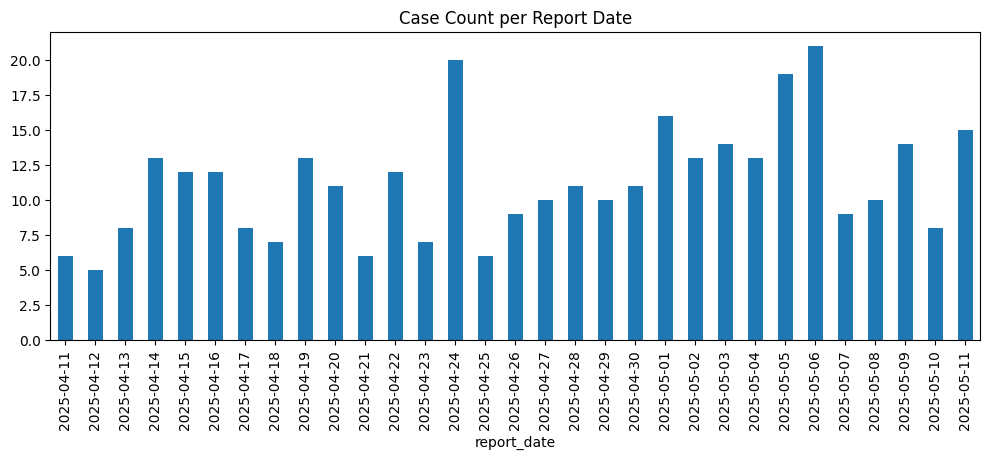

In [55]:
df['report_date'].value_counts().sort_index().plot(kind='bar', figsize=(12,4), title="Case Count per Report Date")

In [56]:
df['disease_name'].nunique()

116

## 📊 Section 2: Grouped Disease and Gender Distribution
✅ **Objective**
Understand the demographic distribution of diseases and identify gender-specific trends.

🧪 **Method**
Group data by disease and gender

Count number of cases per group

Visualize using bar plots

📈 **Insight**
Some diseases show gender skews. These trends could guide further targeted healthcare interventions.



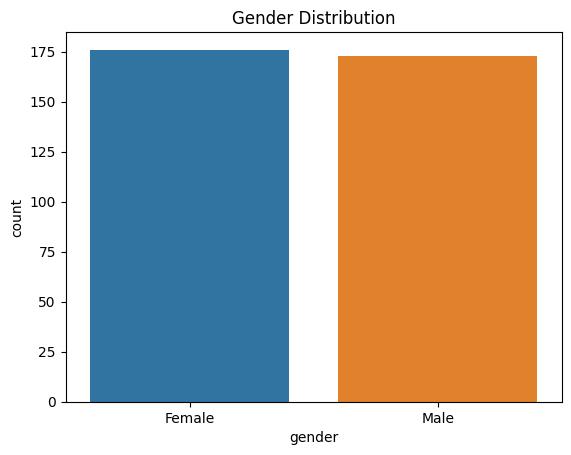

In [57]:
# Gender distribution
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")
plt.show()

In [58]:
## Count number of records per disease
disease_counts = df['disease_name'].value_counts()

# Identify rare diseases
rare_diseases = disease_counts[disease_counts < 10].index

# Create new column with grouped diseases
df['disease_grouped'] = df['disease_name'].apply(lambda x: 'Other' if x in rare_diseases else x)

# Optional: Check new group counts
print(df['disease_grouped'].value_counts())

disease_grouped
Other           266
Asthma           23
Stroke           16
Osteoporosis     14
Hypertension     10
Diabetes         10
Migraine         10
Name: count, dtype: int64


In [59]:
# List of binary symptom columns (adjust if needed)
symptom_cols = ['fever', 'cough', 'fatigue', 'difficulty_breathing', 'high_blood_pressure', 'high_cholesterol']

# Group by disease and calculate average symptom values
symptom_profile = df.groupby('disease_grouped')[symptom_cols].mean().reset_index()

# Display
print(symptom_profile.head())

  disease_grouped     fever     cough   fatigue  difficulty_breathing  \
0          Asthma  0.782609  0.739130  0.478261              0.956522   
1        Diabetes  0.500000  0.500000  0.600000              0.100000   
2    Hypertension  0.500000  0.400000  0.500000              0.000000   
3        Migraine  0.500000  0.500000  0.500000              0.100000   
4    Osteoporosis  0.500000  0.428571  0.571429              0.142857   

   high_blood_pressure  high_cholesterol  
0             0.217391          0.272727  
1             0.400000          0.777778  
2             0.500000          0.428571  
3             0.400000          0.444444  
4             0.500000          0.461538  


## 🔥 Section 3: Symptom Presence Heatmap
✅ **Objective**
Identify which symptoms are most commonly reported for different disease groups.

🧪 **Method**
Map symptoms and health indicators (blood_pressure, cholesterol_level) to the diseases.

Visualize as a heatmap.

📈 **Insight**
Symptoms mostly found in certain disease groups can help map and look for potential diagnosis for future patients.

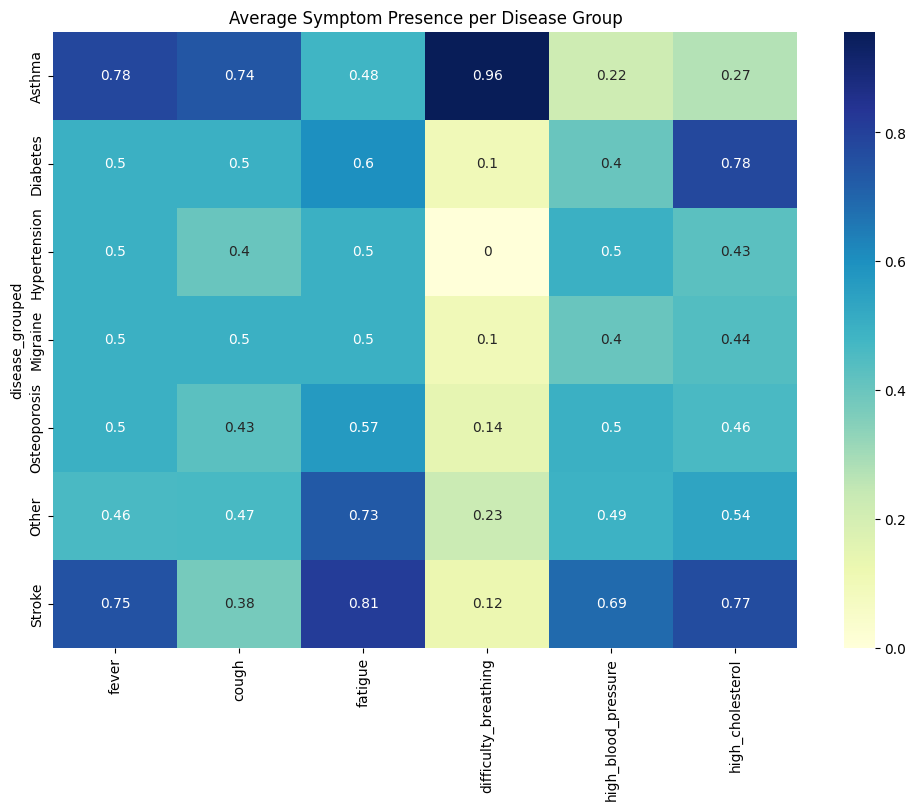

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set index to disease names for heatmap
symptom_heatmap = symptom_profile.set_index('disease_grouped')

plt.figure(figsize=(12, 8))
sns.heatmap(symptom_heatmap, cmap="YlGnBu", annot=True)
plt.title("Average Symptom Presence per Disease Group")
plt.show()

## 🧪 Section 4: Real-Time Symptom Simulation
✅ **Objective**
Simulate how patient symptom data would arrive in a real-time monitoring system.

🧪 **Method**
Shuffle rows to mimic random incoming data

Use time.sleep() to simulate time-delayed streaming

Print live updates with associated symptoms and disease predictions

📈 **Insight**
Demonstrates feasibility of integrating real-time monitoring into healthcare systems, forming the foundation for alerting or triage tools.



In [61]:
import numpy as np
from datetime import datetime, timedelta

start_time = datetime.now()
interval = timedelta(seconds=10)

df['report_time'] = pd.date_range(start=start_time, periods=len(df), freq='10S')

In [62]:
df = df.sort_values(by='report_time').reset_index(drop=True)

In [63]:
import time

for idx, row in df.iterrows():
    print(f"Time: {row['report_time']}, Disease: {row['disease_name']}, Fever: {row['fever']}, Cough: {row['cough']}, Fatigue: {row['fatigue']}, Difficulty breathing: {row['difficulty_breathing']}, High Blood Pressure: {row['high_blood_pressure']}, High Cholesterol: {row['high_cholesterol']}")
    time.sleep(0.5)  # simulate delay like incoming stream

Time: 2025-05-11 21:12:35.221334, Disease: Rheumatoid Arthritis, Fever: 0, Cough: 1, Fatigue: 1, Difficulty breathing: 1, High Blood Pressure: 1, High Cholesterol: 1.0
Time: 2025-05-11 21:12:45.221334, Disease: Dengue Fever, Fever: 1, Cough: 0, Fatigue: 1, Difficulty breathing: 0, High Blood Pressure: 0, High Cholesterol: 0.0
Time: 2025-05-11 21:12:55.221334, Disease: Hypertension, Fever: 1, Cough: 1, Fatigue: 1, Difficulty breathing: 0, High Blood Pressure: 1, High Cholesterol: 0.0
Time: 2025-05-11 21:13:05.221334, Disease: Rubella, Fever: 1, Cough: 0, Fatigue: 1, Difficulty breathing: 0, High Blood Pressure: 1, High Cholesterol: 0.0
Time: 2025-05-11 21:13:15.221334, Disease: Diabetes, Fever: 0, Cough: 1, Fatigue: 0, Difficulty breathing: 0, High Blood Pressure: 0, High Cholesterol: 1.0
Time: 2025-05-11 21:13:25.221334, Disease: Common Cold, Fever: 1, Cough: 0, Fatigue: 1, Difficulty breathing: 1, High Blood Pressure: 0, High Cholesterol: nan
Time: 2025-05-11 21:13:35.221334, Disease:

In [64]:
print(df.columns)

Index(['disease_name', 'fever', 'cough', 'fatigue', 'difficulty_breathing',
       'age', 'gender', 'high_blood_pressure', 'high_cholesterol', 'outcome',
       'timestamp', 'report_date', 'disease_grouped', 'report_time'],
      dtype='object')


In [65]:
df[symptom_cols] = df[symptom_cols].fillna(0).astype(int)

## 📊 Section 5: Bar Chart of Symptom Occurrence
✅ **Objective**
Visually compare how often each symptom appears in the dataset.

🧪 **Method**
Aggregate and sort total symptom counts

Plot a readable bar chart using matplotlib with rotated x-axis labels

📈 **Insight**
This visualization reinforces data imbalance and symptom prominence, useful for triage or alert systems.

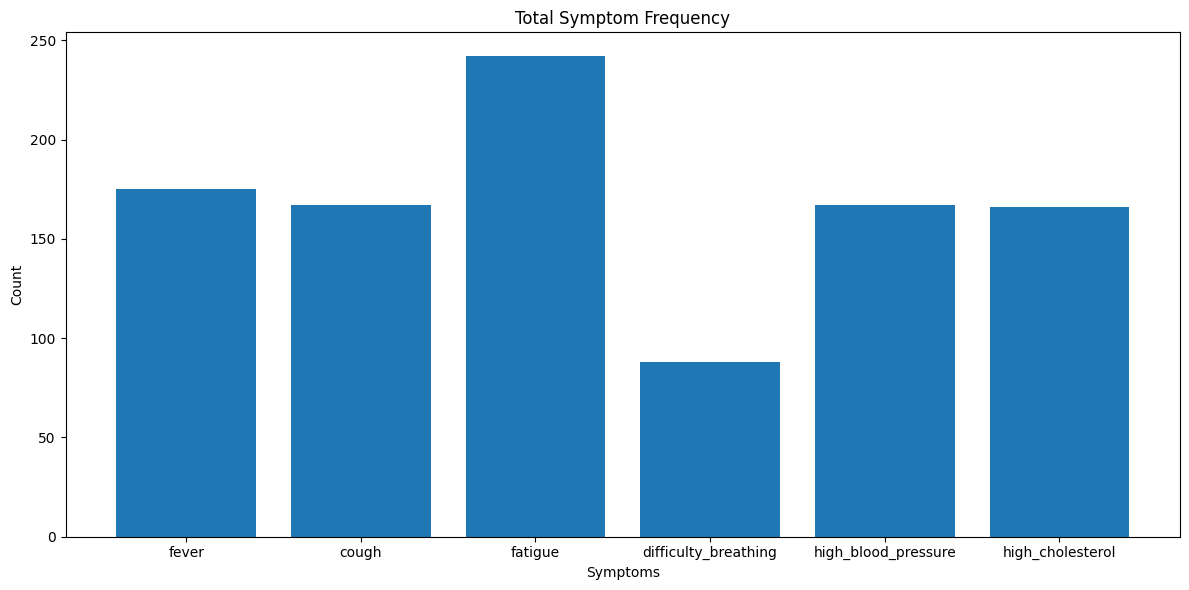

In [66]:
# Define the symptom columns
symptom_cols = ['fever', 'cough', 'fatigue', 'difficulty_breathing', 'high_blood_pressure', 'high_cholesterol']

df[symptom_cols] = df[symptom_cols].astype(int)

symptom_counts = df[symptom_cols].sum()
plt.figure(figsize=(12,6))
plt.bar(symptom_counts.index, symptom_counts.values)
plt.title("Total Symptom Frequency")
plt.xlabel("Symptoms")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 📈 Section 6: Symptom Prevalence for Top 20 Diseases
✅ **Objective**
Compare how often each symptom appears per disease, using prevalence rates.

🧪 **Method**
Select top 20 most common diseases by case count.

Group by disease and calculate mean of each binary symptom.

Visualize as a heatmap.

📈 **Insight**
This disease-symptom matrix gives a diagnostic overview useful for clinical decision support tools or machine learning models.

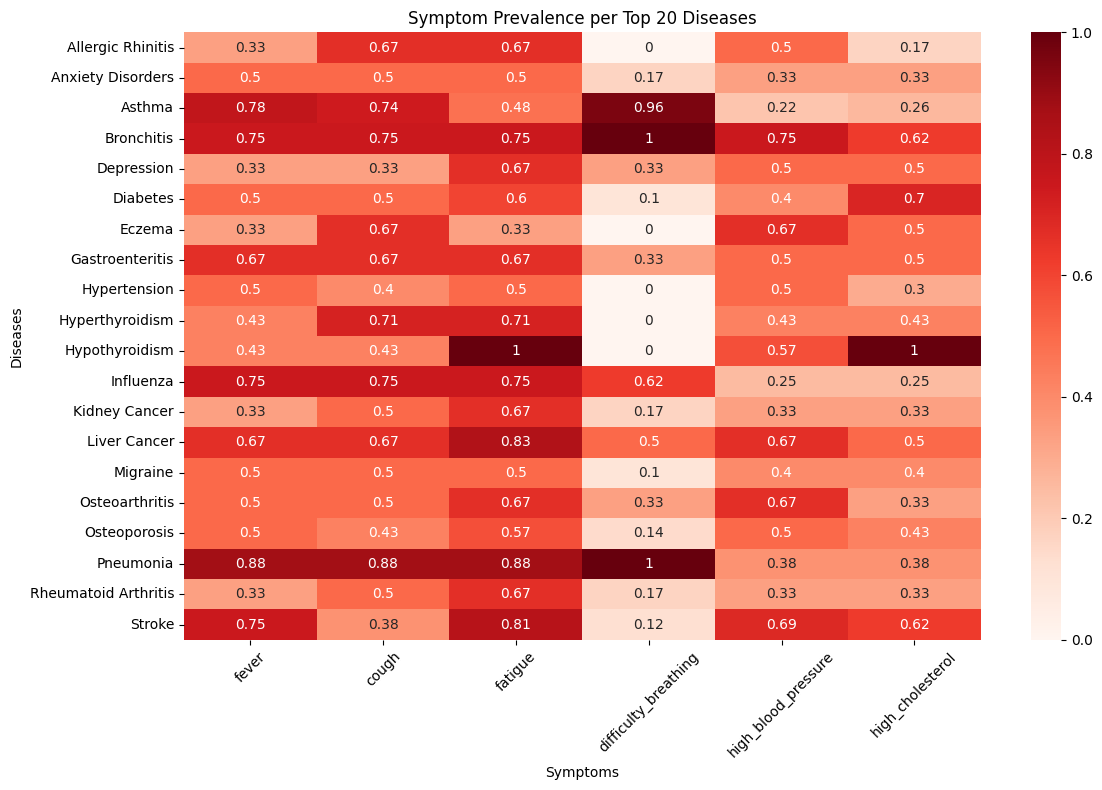

In [67]:
# Select top 20 most common diseases
top_diseases = df['disease_name'].value_counts().head(20).index
top_df = df[df['disease_name'].isin(top_diseases)]

# Calculate prevalence (mean of binary values) of symptoms per disease
symptom_prevalence = top_df.groupby('disease_name')[symptom_cols].mean()

# Heatmap of symptom prevalence
plt.figure(figsize=(12, 8))
sns.heatmap(symptom_prevalence, annot=True, cmap='Reds')
plt.title("Symptom Prevalence per Top 20 Diseases")
plt.xlabel("Symptoms")
plt.ylabel("Diseases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🧠Section 7: NLP Analysis Using spaCy
✅ **Objective**
Extract key medical terms and insights from free-form clinical text.

🧪 **Method**
Use spaCy to process sample patient descriptions

Extract noun phrases and chunks

Set groundwork for named entity recognition (NER) or classification

📈 **Insight**
Unstructured data from patient reports can be systematically processed for additional insights, enriching structured datasets.



In [68]:
from scipy.stats import chi2_contingency

# Store p-values for each symptom
chi2_results = {}

for symptom in symptom_cols:
    contingency = pd.crosstab(df[symptom], df['disease_name'])
    if contingency.shape[0] < 2:  # Skip symptoms with no variation
        continue
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results[symptom] = p

# Sort symptoms by significance (lowest p-value)
sorted_symptoms = sorted(chi2_results.items(), key=lambda x: x[1])

# Display top significant associations
for symptom, p in sorted_symptoms[:5]:
    print(f"Symptom: {symptom}, p-value: {p:.4e}")

Symptom: difficulty_breathing, p-value: 7.2073e-09
Symptom: high_cholesterol, p-value: 5.0201e-02
Symptom: fever, p-value: 1.0877e-01
Symptom: high_blood_pressure, p-value: 2.5395e-01
Symptom: cough, p-value: 2.8811e-01


In [69]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [70]:
# Unique disease names
diseases = df['disease_name'].dropna().unique().tolist()

# Use spaCy to extract noun phrases
disease_phrases = []
for disease in diseases[:20]:  # Limit to first 20 for brevity
    doc = nlp(disease)
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]
    disease_phrases.append((disease, noun_chunks if noun_chunks else [disease]))

# Print examples
for d, phrases in disease_phrases[:5]:
    print(f"{d}: {phrases}")

Rheumatoid Arthritis: ['Rheumatoid Arthritis']
Dengue Fever: ['Dengue Fever']
Hypertension: ['Hypertension']
Rubella: ['Rubella']
Diabetes: ['Diabetes']


In [71]:
def get_symptom_summary(symptom_row):
    symptoms = {
        'fever': 'fever',
        'cough': 'persistent cough',
        'fatigue': 'unusual fatigue',
        'difficulty_breathing': 'difficulty in breathing',
        'high_blood_pressure' : 'increase in blood pressure',
        'high_cholesterol' : 'increase in cholesterol'
    }
    return [desc for key, desc in symptoms.items() if symptom_row.get(key) == 1]


# Create summaries for top 5 diseases
for disease in df['disease_name'].value_counts().head(5).index:
    subset = df[df['disease_name'] == disease]
    gender_dist = subset['gender'].value_counts(normalize=True).to_dict()
    age_avg = int(subset['age'].mean())

    common_symptoms = subset[['fever', 'cough', 'fatigue', 'difficulty_breathing', 'high_blood_pressure', 'high_cholesterol']].mean().round(2)
    active_symptoms = [symptom for symptom, freq in common_symptoms.items() if freq > 0.5]

    readable_symptoms = get_symptom_summary({sym: 1 for sym in active_symptoms})

    summary = f"""
📌 Disease: {disease}
- Average Patient Age: {age_avg}
- Most Common Symptoms: {', '.join(readable_symptoms)}
- Gender Distribution: {', '.join([f"{k}: {v:.0%}" for k, v in gender_dist.items()])}
    """
    print(summary)


📌 Disease: Asthma
- Average Patient Age: 36
- Most Common Symptoms: fever, persistent cough, difficulty in breathing
- Gender Distribution: Male: 52%, Female: 48%
    

📌 Disease: Stroke
- Average Patient Age: 65
- Most Common Symptoms: fever, unusual fatigue, increase in blood pressure, increase in cholesterol
- Gender Distribution: Female: 56%, Male: 44%
    

📌 Disease: Osteoporosis
- Average Patient Age: 54
- Most Common Symptoms: unusual fatigue
- Gender Distribution: Male: 57%, Female: 43%
    

📌 Disease: Migraine
- Average Patient Age: 41
- Most Common Symptoms: 
- Gender Distribution: Female: 60%, Male: 40%
    

📌 Disease: Hypertension
- Average Patient Age: 52
- Most Common Symptoms: 
- Gender Distribution: Female: 60%, Male: 40%
    


## ✅ Final Conclusion
**Built an end-to-end symptom monitoring pipeline** using Python, SQL (BigQuery), and GCP.

Combined **time-series simulation, symptom analytics, and NLP extraction** for actionable healthcare insights.

Lightweight but impactful — aligns with real-world needs in **triage, diagnosis, and digital healthcare tools**.

Ready for extension into forecasting, alert systems, or integration with cloud-based dashboards.

